<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu4/Minggu4_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.9 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from IPython.display import display, Markdown
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import copy
from transformers import EsmModel, EsmConfig
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For all GPUs
    torch.cuda.manual_seed_all(seed) # For all GPUs

    # Ensures that CUDA operations are deterministic even if they might be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed} for reproducibility.")

# Call the function to set the seed
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Random seed set to 42 for reproducibility.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df_pdb = pd.read_csv('/content/PDB1063-186.csv')
df_uni = pd.read_csv('/content/UniSwiss.csv')

def show_dataset_info(df, dataset_name, stage="Before Cleaning"):
    """Menampilkan informasi dataset"""
    if df is None or df.empty:
        print(f"{stage} - Dataset {dataset_name} is empty")
        return

    total_rows = len(df)
    train_count = len(df[df['set'] == 'train'])
    test_count = len(df[df['set'] == 'test'])

    train_label_0 = len(df[(df['set'] == 'train') & (df['label'] == 0)])
    train_label_1 = len(df[(df['set'] == 'train') & (df['label'] == 1)])
    test_label_0 = len(df[(df['set'] == 'test') & (df['label'] == 0)])
    test_label_1 = len(df[(df['set'] == 'test') & (df['label'] == 1)])

    print(f"\n{stage} - {dataset_name} Dataset:")
    print(f"Total rows: {total_rows}")
    print(f"Train set: {train_count} rows")
    print(f"  - Label 0: {train_label_0} rows")
    print(f"  - Label 1: {train_label_1} rows")
    print(f"Test set: {test_count} rows")
    print(f"  - Label 0: {test_label_0} rows")
    print(f"  - Label 1: {test_label_1} rows")

def cleaning_crossset_duplicates(df, dataset_name=None):
    """
    Membersihkan duplikat cross-set: jika sequence muncul di test dan train,
    hapus hanya dari TRAIN, test tetap dipertahankan.
    """

    print(f"\n=== Checking Cross-Set Duplicates ({dataset_name}) ===")

    # Info awal
    show_dataset_info(df, dataset_name, "Before Cleaning")

    # Pisahkan train/test
    train_df = df[df["set"] == "train"].copy()
    test_df = df[df["set"] == "test"].copy()

    # Ambil sequence
    train_seq = set(train_df["sequence"].tolist())
    test_seq = set(test_df["sequence"].tolist())

    # Cari duplikat antar set
    overlap = train_seq.intersection(test_seq)
    print(f"Cross-set duplicates (train ∩ test): {len(overlap)}")

    # Hapus dari TRAIN
    train_clean = train_df[~train_df["sequence"].isin(overlap)]

    rows_removed = len(train_df) - len(train_clean)
    print(f"Rows removed from TRAIN: {rows_removed}")

    # Gabungkan kembali
    df_clean = pd.concat([train_clean, test_df], ignore_index=True)

    # Info final
    show_dataset_info(df_clean, dataset_name, "After Cleaning")

    return df_clean


# Proses cleaning dengan menampilkan info
print("=" * 50)
print("DATASET CLEANING PROCESS")
print("=" * 50)

df_pdb_clean = cleaning_crossset_duplicates(df_pdb, "PDB")
print("\n" + "=" * 50)
df_uni_clean = cleaning_crossset_duplicates(df_uni, "UniSwiss")
print("\n" + "=" * 50)

# Summary akhir
print("\nFINAL SUMMARY:")
print(f"PDB dataset - Final count: {len(df_pdb_clean)}")
print(f"UniSwiss dataset - Final count: {len(df_uni_clean)}")
print(f"Combined total: {len(df_pdb_clean) + len(df_uni_clean)}")

DATASET CLEANING PROCESS

=== Checking Cross-Set Duplicates (PDB) ===

Before Cleaning - PDB Dataset:
Total rows: 1249
Train set: 1063 rows
  - Label 0: 545 rows
  - Label 1: 518 rows
Test set: 186 rows
  - Label 0: 93 rows
  - Label 1: 93 rows
Cross-set duplicates (train ∩ test): 75
Rows removed from TRAIN: 75

After Cleaning - PDB Dataset:
Total rows: 1174
Train set: 988 rows
  - Label 0: 545 rows
  - Label 1: 443 rows
Test set: 186 rows
  - Label 0: 93 rows
  - Label 1: 93 rows


=== Checking Cross-Set Duplicates (UniSwiss) ===

Before Cleaning - UniSwiss Dataset:
Total rows: 9762
Train set: 9000 rows
  - Label 0: 4500 rows
  - Label 1: 4500 rows
Test set: 762 rows
  - Label 0: 381 rows
  - Label 1: 381 rows
Cross-set duplicates (train ∩ test): 3
Rows removed from TRAIN: 35

After Cleaning - UniSwiss Dataset:
Total rows: 9727
Train set: 8965 rows
  - Label 0: 4500 rows
  - Label 1: 4465 rows
Test set: 762 rows
  - Label 0: 381 rows
  - Label 1: 381 rows


FINAL SUMMARY:
PDB dataset 

# Supcon

In [ ]:
# Load ESM2 tokenizer + model (HuggingFace)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
esm_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=320, out_features=1280, bias=True)
        )
        (output): EsmOutput(
        

##Define Function and class


In [ ]:
class ESMBackbone(nn.Module):
    def __init__(self, proj_dim=128, in_dim=320, model_name="facebook/esm2_t6_8M_UR50D"):
        super().__init__()
        self.hidden_dim = in_dim  # <— tambahkan ini!

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.esm = EsmModel.from_pretrained(model_name)

        self.proj = nn.Linear(in_dim, proj_dim)

    def forward(self, x, return_proj=False):
        # CASE 1 → RAW SEQUENCE (list of strings)
        if isinstance(x[0], str):
            tokens = self.tokenizer(
                x, padding=True, truncation=True, return_tensors='pt'
            ).to(self.proj.weight.device)

            out = self.esm(**tokens)
            h = out.last_hidden_state[:, 0]   # CLS embedding

        # CASE 2 → EMBEDDING (tensor)
        else:
            h = x.to(self.proj.weight.device)

        z = self.proj(h)
        return z if return_proj else h



class SupConLoss(nn.Module):
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8

    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)

        features = nn.functional.normalize(features, dim=1)

        # cosine similarity matrix
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        labels = labels.unsqueeze(0) == labels.unsqueeze(1)
        mask = labels.float().to(device)

        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        logits = sim_matrix - logits_max.detach()

        exp_logits = torch.exp(logits) * (1 - torch.eye(batch_size).to(device))

        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + self.eps)

        loss = -mean_log_prob_pos.mean()
        return loss

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, n_classes)
        )

    def forward(self, x):
        return self.net(x)

class FullModel(nn.Module):
    def __init__(self, backbone, classifier):
        super().__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, seqs):
        # seqs: list of strings OR tensor embeddings
        with torch.no_grad():
            emb = self.backbone(seqs)
        logits = self.classifier(emb)
        return logits



class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ProteinSupConDataset(Dataset):
    """
    Dataset untuk Supervised Contrastive Learning di protein.
    Positive pair:
      1. Dari augmentasi sequence (selalu)
      2. Dari sequence lain dengan label sama (opsional)
    """
    def __init__(self, sequences, labels, augment=True, use_label_pos=False):
        """
        sequences : list of str
        labels : list of int
        augment : bool, gunakan protein-aware augmentation
        use_label_pos : bool, jadikan sequence lain dengan label sama sebagai positive pair tambahan
        """
        self.sequences = sequences
        self.labels = labels
        self.augment = augment
        self.use_label_pos = use_label_pos

        # Mapping label -> index list
        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            self.label_to_indices.setdefault(label, []).append(idx)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]

        # 1. Augmentasi sequence → selalu ada 2 versi
        if self.augment:
            seq1 = augment_protein_sequence(seq)
            seq2 = augment_protein_sequence(seq)
        else:
            seq1 = seq2 = seq

        positive_pairs = [[seq1, seq2]]

        # 2. Tambahkan positive dari label sama (opsional)
        if self.use_label_pos:
            same_label_indices = self.label_to_indices[label].copy()
            same_label_indices.remove(idx)  # hapus diri sendiri
            if same_label_indices:
                # ambil 1 random sequence lain dengan label sama
                idx2 = random.choice(same_label_indices)
                seq_pos = self.sequences[idx2]
                if self.augment:
                    seq_pos = augment_protein_sequence(seq_pos)
                positive_pairs.append([seq1, seq_pos])

        return positive_pairs, label



In [ ]:
def train_supcon(backbone, train_loader, val_loader, epochs=10, lr=1e-4, device=device):
    backbone = backbone.to(device)
    criterion = SupConLoss()
    optimizer = torch.optim.AdamW(backbone.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    train_losses, val_losses = [], []
    print("\n🚀 Starting SupCon Pretraining (Safe)...\n")

    for epoch in range(1, epochs+1):
        backbone.train()
        total_train_loss = 0

        for X, y in train_loader:
            y = y.to(device)

            # Raw sequence → list of strings
            if isinstance(X[0], str):
                inp = list(X)
            else:
                inp = X.to(device)

            # Forward backbone → embedding
            proj = backbone(inp, return_proj=True)

            # Jika batch terlalu kecil, SupConLoss masih jalan
            if proj.size(0) != y.size(0):
                raise ValueError(f"Batch size mismatch: proj {proj.size(0)} vs labels {y.size(0)}")

            loss = criterion(proj, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # ===== Validation =====
        backbone.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                y = y.to(device)

                if isinstance(X[0], str):
                    inp = list(X)
                else:
                    inp = X.to(device)

                proj = backbone(inp, return_proj=True)
                total_val_loss += criterion(proj, y).item()

        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    return backbone, train_losses, val_losses



def train_classifier(
    backbone, classifier, train_loader, val_loader,
    epochs=20, lr=1e-3, device=device
):
    # ============================
    #  Setup BackBone (Freeze)
    # ============================
    backbone = backbone.to(device)
    backbone.eval()
    for p in backbone.parameters():
        p.requires_grad = False

    classifier = classifier.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    # history
    train_losses = []
    val_losses = []
    val_accs   = []

    # ============================
    #  TRAINING LOOP
    # ============================
    for epoch in range(1, epochs + 1):
        classifier.train()
        total_train_loss = 0.0

        for X, y in train_loader:
            y = y.to(device)

            # input is string or tensor?
            if isinstance(X[0], str):
                inp = list(X)
            else:
                inp = X.to(device)

            # get embeddings from frozen backbone
            with torch.no_grad():
                emb = backbone(inp)

            # forward classifier
            logits = classifier(emb)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ============================
        # VALIDATION
        # ============================
        classifier.eval()
        total_val_loss = 0.0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for X, y in val_loader:
                y = y.to(device)

                if isinstance(X[0], str):
                    inp = list(X)
                else:
                    inp = X.to(device)

                emb = backbone(inp)
                logits = classifier(emb)

                total_val_loss += criterion(logits, y).item()

                preds_all.extend(torch.argmax(logits, 1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = accuracy_score(labels_all, preds_all)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Acc: {val_acc:.3f}")

    # return 4 value
    return classifier, train_losses, val_losses, val_accs


@torch.no_grad()
def esm_embed_sequences(seqs):
    embeddings = []

    for seq in seqs:
        tokens = tokenizer(
            seq,
            return_tensors="pt",
            truncation=True,
            max_length=1024
        )

        tokens = {k: v.to(device) for k, v in tokens.items()}
        out = esm_model(**tokens)
        cls = out.last_hidden_state[:, 0].squeeze().cpu()
        embeddings.append(cls)

    return torch.stack(embeddings)  # tensor (N, 320)

import random

# ================================
# Protein-Aware Augmentation
# ================================
aa_groups = {
    "A": ["G", "S", "T"],  # small polar
    "R": ["K", "H"],       # positive charge
    "N": ["Q", "D"],       # polar
    "D": ["E", "N"],       # negative
    "C": ["S"],            # special
    "E": ["D", "Q"],
    "Q": ["N", "E"],
    "G": ["A", "S"],
    "H": ["R", "K"],
    "I": ["L", "V"],
    "L": ["I", "V"],
    "K": ["R", "H"],
    "M": ["L"],
    "F": ["Y", "W"],
    "P": ["A"],
    "S": ["T", "A"],
    "T": ["S", "A"],
    "W": ["F", "Y"],
    "Y": ["F", "W"],
    "V": ["I", "L"],
}

def random_substitution(seq, prob=0.1):
    """Ganti beberapa AA dengan AA sejenis (conservative)."""
    seq_aug = ""
    for aa in seq:
        if aa in aa_groups and random.random() < prob:
            seq_aug += random.choice(aa_groups[aa])
        else:
            seq_aug += aa
    return seq_aug

def random_mask(seq, prob=0.05):
    """Ganti beberapa AA dengan X (masking)."""
    return "".join([aa if random.random() > prob else "X" for aa in seq])

def random_crop(seq, crop_len=100):
    """Ambil subsekuens panjang crop_len."""
    if len(seq) <= crop_len:
        return seq
    start = random.randint(0, len(seq) - crop_len)
    return seq[start:start+crop_len]

# ================================
# Augmentation pipeline
# ================================
def augment_protein_sequence(seq):
    seq = random_substitution(seq, prob=0.1)
    seq = random_mask(seq, prob=0.05)
    seq = random_crop(seq, crop_len=256)  # atau sesuai max length ESM
    return seq




In [ ]:
#versi perplexity
# bedanya dg yg sebelumnya itu ini ga pke augmentasi
class ProteinSupConDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# pke mean pooling
class ESMBackbone(nn.Module):
    def __init__(self, proj_dim=128, in_dim=320, model_name="facebook/esm2_t6_8M_UR50D"):
        super().__init__()
        self.hidden_dim = in_dim  # <— tambahkan ini!

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.esm = EsmModel.from_pretrained(model_name)

        self.proj = nn.Linear(in_dim, proj_dim)

    def forward(self, x, return_proj=False):
        # CASE 1 → RAW SEQUENCE (list of strings)
        if isinstance(x[0], str):
            tokens = self.tokenizer(
                x, padding=True, truncation=True, return_tensors='pt'
            ).to(self.proj.weight.device)

            out = self.esm(**tokens)
            h = out.last_hidden_state.mean(dim=1)  # Mean pooling seluruh token

        # CASE 2 → EMBEDDING (tensor)
        else:
            h = x.to(self.proj.weight.device)

        z = self.proj(h)
        return z if return_proj else h



##Evaluate and Visualize


In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()

    all_preds = []
    all_labels = []
    all_prob = []

    for X, y in dataloader:
        y = y.to(device)

        # If input is raw AA sequences (list of str)
        if isinstance(X[0], str):
            inp = list(X)
        else:
            inp = X.to(device)

        logits = model(inp)
        probs = logits.softmax(dim=1)

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_prob.extend(probs.cpu().numpy())

    # Convert to numpy
    y_true = all_labels
    y_pred = all_preds
    y_prob = all_prob

    # ============================
    #          METRICS
    # ============================
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    # ROC-AUC hanya untuk binary (kelas 1)
    roc_auc = roc_auc_score(y_true, [p[1] for p in y_prob])

    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Classification report
    class_report = classification_report(
        y_true, y_pred,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3
    )

    # ============================
    #     PRINT HASIL
    # ============================
    print("\n=== Evaluation Result ===")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision(M):  {precision_macro:.3f}")
    print(f"Recall(M):     {recall_macro:.3f}")
    print(f"F1 Macro:      {f1_macro:.3f}")
    print(f"F1 Weighted:   {f1_weighted:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"ROC-AUC:       {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # ============================
    #     CONFUSION MATRIX PLOT
    # ============================
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-binding", "Binding"],
                yticklabels=["Non-binding", "Binding"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "MCC": mcc,
        "Specificity": specificity,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }, y_pred, y_prob

In [ ]:
# Function to visualize the confusion matrix and ROC curve
def visualize_metrics(y_true_pdb, y_pred_pdb, y_prob_pdb, y_true_uni, y_pred_uni, y_prob_uni, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true_pdb, y_pred_pdb, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true_uni, y_pred_uni, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_true_pdb, y_prob_pdb[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true_uni, y_prob_uni[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##Execution

### load dll

In [ ]:
df_pdb_train = df_pdb_clean[df_pdb_clean['set'] == 'train']
df_pdb_test  = df_pdb_clean[df_pdb_clean['set'] == 'test']

x_pdb_train_emb = esm_embed_sequences(df_pdb_train['sequence'])
x_pdb_test_emb  = esm_embed_sequences(df_pdb_test['sequence'])

y_pdb_train = df_pdb_train['label'].values
y_pdb_test  = df_pdb_test['label'].values

X_pdb_train, X_pdb_val, y_pdb_train, y_pdb_val = train_test_split(
    x_pdb_train_emb,
    y_pdb_train,
    test_size=0.1,
    random_state=42,
    stratify=y_pdb_train
)

# UNI
df_uni_train = df_uni_clean[df_uni_clean['set'] == 'train']
df_uni_test  = df_uni_clean[df_uni_clean['set'] == 'test']

x_uni_train_emb = esm_embed_sequences(df_uni_train['sequence'])
x_uni_test_emb  = esm_embed_sequences(df_uni_test['sequence'])

y_uni_train = df_uni_train['label'].values
y_uni_test  = df_uni_test['label'].values

X_uni_train, X_uni_val, y_uni_train, y_uni_val = train_test_split(
    x_uni_train_emb,
    y_uni_train,
    test_size=0.1,
    random_state=42,
    stratify=y_uni_train
)

In [ ]:
batch_size = 32

# PDB
train_ds_pdb = SequenceDataset(X_pdb_train, y_pdb_train)
val_ds_pdb   = SequenceDataset(X_pdb_val,   y_pdb_val)
test_ds_pdb  = SequenceDataset(x_pdb_test_emb,  y_pdb_test)


train_loader_pdb = DataLoader(train_ds_pdb, batch_size=32, shuffle=True)
val_loader_pdb   = DataLoader(val_ds_pdb,   batch_size=32)
test_loader_pdb   = DataLoader(test_ds_pdb,   batch_size=32)

# UNI
train_ds_uni = SequenceDataset(X_uni_train, y_uni_train)
val_ds_uni   = SequenceDataset(X_uni_val,   y_uni_val)
test_ds_uni  = SequenceDataset(x_uni_test_emb,  y_uni_test)


train_loader_uni = DataLoader(train_ds_uni, batch_size=32, shuffle=True)
val_loader_uni   = DataLoader(val_ds_uni,   batch_size=32)
test_loader_uni   = DataLoader(test_ds_uni,   batch_size=32)


### train (0.704)
pke augmentation


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
# backbone = ESMBackbone(proj_dim=128)
# backbone.load_state_dict(torch.load("supcon_esm_backbone.pt", map_location="cuda"))
# backbone.to("cuda")
# backbone.eval()

# print("Loaded SupCon-trained ESM backbone ✔")


In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 2 (0.692)
ga pke augmentation


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3 (0.720)
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3.2 (0.717) 200 epoch
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=200, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3.3 (0.713) 500 epoch
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=500, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 4 (0.749)
ga pke augmentation + pke mean pooling + pke asymetric threshold


In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from IPython.display import display
# Asumsi: Anda sudah mendefinisikan ComplexMLP_v3, train_model_v3, evaluate_model_new, visualize_metrics
# dan variabel data: x_train_pdb, y_train_pdb, x_val_pdb, y_val_pdb, x_pdb_test_emb, y_pdb_test,
# x_train_uni, y_train_uni, x_uni_test_emb, y_uni_test

# --- FUNGSI UTILITY (Disediakan oleh User) ---

def find_best_asymmetric_threshold(probs_class1, true_labels, thresholds_range):
    """
    Mencari pasangan threshold (T0 dan T1) terbaik untuk memaksimalkan F1 Macro pada Validation/Test Set.
    T1: Threshold untuk memprediksi Kelas 1 (Binding)
    T0: Threshold untuk memprediksi Kelas 0 (Non-binding)
    """
    best_f1_macro = 0
    best_threshold_pair = (0.5, 0.5)

    probs_class0 = 1 - probs_class1

    print(f"Menguji {len(thresholds_range)**2} kombinasi T0/T1...")

    for T1 in thresholds_range: # Loop untuk Threshold Kelas 1
        for T0 in thresholds_range: # Loop untuk Threshold Kelas 0

            # --- Logika Prediksi Asimetris ---
            predictions = np.zeros_like(true_labels, dtype=int)
            predictions[probs_class1 >= T1] = 1 # Prediksi 1 jika confidence 1 tinggi
            predictions[probs_class0 >= T0] = 0 # Prediksi 0 jika confidence 0 tinggi (menimpa Kondisi 1 jika berbenturan)

            f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)

            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold_pair = (T0, T1)

    return best_threshold_pair, best_f1_macro

def get_probabilities_and_labels(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) # Probabilitas Kelas 1
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def verify_best_asymmetric_threshold(probs_class1, true_labels, best_T0, best_T1):
    probs_class0 = 1 - probs_class1
    final_predictions = np.zeros_like(true_labels, dtype=int)

    final_predictions[probs_class1 >= best_T1] = 1
    final_predictions[probs_class0 >= best_T0] = 0

    print(f"\n=== Classification Report (Test Set) dengan Threshold Asimetris T0={best_T0:.4f}, T1={best_T1:.4f} ===")
    print(classification_report(true_labels, final_predictions,
                                 target_names=['Non-binding (0)', 'Binding (1)'],
                                 zero_division=0))
    # Hitung dan kembalikan F1 Macro final
    f1_macro_final = f1_score(true_labels, final_predictions, average='macro', zero_division=0)
    print(f"F1 Macro Final: {f1_macro_final:.4f}")
    return f1_macro_final



In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=200, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/200 | Train: 3.4332 | Val: 2.5623
Epoch 2/200 | Train: 3.3934 | Val: 2.5726
Epoch 3/200 | Train: 3.3859 | Val: 2.5563
Epoch 4/200 | Train: 3.3742 | Val: 2.5210
Epoch 5/200 | Train: 3.3678 | Val: 2.4778
Epoch 6/200 | Train: 3.3519 | Val: 2.4133
Epoch 7/200 | Train: 3.3417 | Val: 2.3611
Epoch 8/200 | Train: 3.3308 | Val: 2.3070
Epoch 9/200 | Train: 3.3258 | Val: 2.2775
Epoch 10/200 | Train: 3.3171 | Val: 2.2542
Epoch 11/200 | Train: 3.3039 | Val: 2.1930
Epoch 12/200 | Train: 3.2990 | Val: 2.1626
Epoch 13/200 | Train: 3.2846 | Val: 2.1023
Epoch 14/200 | Train: 3.2857 | Val: 2.1569
Epoch 15/200 | Train: 3.2755 | Val: 2.1316
Epoch 16/200 | Train: 3.2696 | Val: 2.1346
Epoch 17/200 | Train: 3.2579 | Val: 1.9829
Epoch 18/200 | Train: 3.2600 | Val: 2.0800
Epoch 19/200 | Train: 3.2457 | Val: 1.9989
Epoch 20/200 | Train: 3.2470 | Val: 1.9734
Epoch 21/200 | Train: 3.2304 | Val: 1.9589
Epoch 22/200 | Train: 3.2331 | Val: 1.9750
Epoch 23/200 | Train:

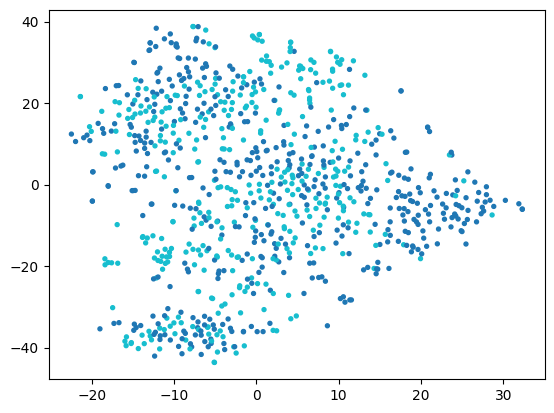

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


Mulai train classifier...
Epoch 1/20 | Train Loss: 0.6809 | Val Loss: 0.6417 | Acc: 0.667
Epoch 2/20 | Train Loss: 0.6255 | Val Loss: 0.5098 | Acc: 0.727
Epoch 3/20 | Train Loss: 0.5414 | Val Loss: 0.4148 | Acc: 0.788
Epoch 4/20 | Train Loss: 0.5359 | Val Loss: 0.3640 | Acc: 0.838
Epoch 5/20 | Train Loss: 0.5017 | Val Loss: 0.3578 | Acc: 0.828
Epoch 6/20 | Train Loss: 0.4969 | Val Loss: 0.3898 | Acc: 0.808
Epoch 7/20 | Train Loss: 0.4671 | Val Loss: 0.3295 | Acc: 0.798
Epoch 8/20 | Train Loss: 0.4554 | Val Loss: 0.3312 | Acc: 0.808
Epoch 9/20 | Train Loss: 0.4633 | Val Loss: 0.3604 | Acc: 0.828
Epoch 10/20 | Train Loss: 0.4445 | Val Loss: 0.3341 | Acc: 0.808
Epoch 11/20 | Train Loss: 0.4758 | Val Loss: 0.3463 | Acc: 0.808
Epoch 12/20 | Train Loss: 0.4333 | Val Loss: 0.3304 | Acc: 0.798
Epoch 13/20 | Train Loss: 0.4315 | Val Loss: 0.3344 | Acc: 0.798
Epoch 14/20 | Train Loss: 0.4243 | Val Loss: 0.3566 | Acc: 0.838
Epoch 15/20 | Train Loss: 0.4215 | Val Loss: 0.3662 | Acc: 0.808
Epoch 16

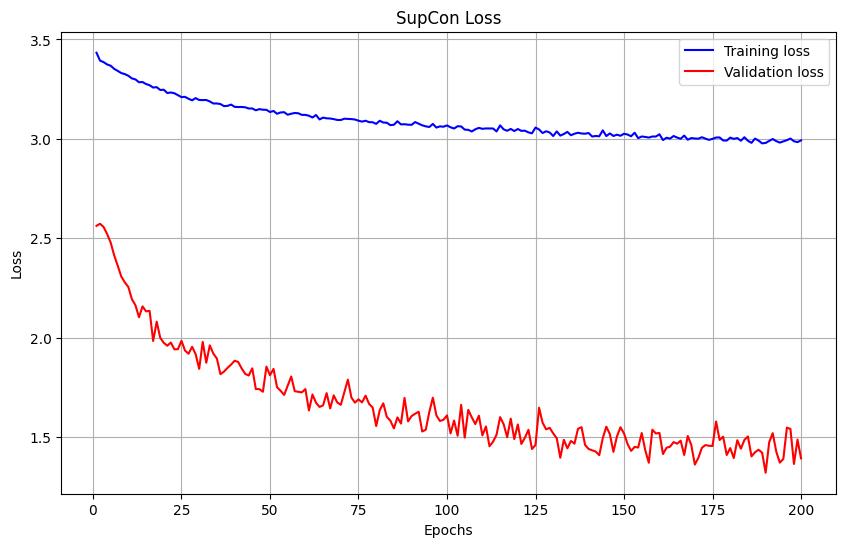

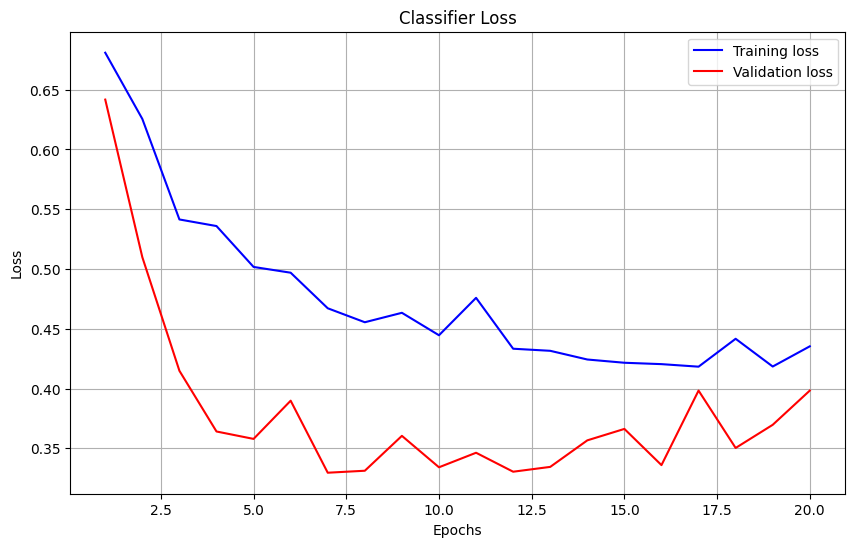

In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)



In [ ]:

# Range ambang batas (contoh: 0.1, 0.15, 0.2, ..., 0.95, 0.99)
thresholds_range = np.linspace(0.1, 0.99, 101)
print(f"Range ambang batas yang diuji: {thresholds_range}")


# 2. Ambil Probabilitas dari Model yang Sudah Dilatih (PDB Model)
# Gunakan model yang sudah Anda latih (trained_pdb_model)
probs_class1_test, true_labels_test = get_probabilities_and_labels(model, test_loader_pdb, device)

# 3. Cari Ambang Batas Asimetris Terbaik pada TEST SET
# (Penting: Dalam praktik murni, ini dilakukan pada Validation Set)
# Kami melakukannya di Test Set di sini karena alur Anda adalah single-split evaluation.

print("\n--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---")
(best_T0, best_T1), max_f1 = find_best_asymmetric_threshold(probs_class1_test, true_labels_test, thresholds_range)

print("\n========================================================")
print(f"HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):")
print(f"T0 (Kelas 0 Non-binding) = {best_T0:.4f}")
print(f"T1 (Kelas 1 Binding)     = {best_T1:.4f}")
print(f"F1 Macro Terbaik         = {max_f1:.4f}")
print("========================================================\n")


# 4. Verifikasi dan Tampilkan Laporan Final
verify_best_asymmetric_threshold(probs_class1_test, true_labels_test, best_T0, best_T1)

Range ambang batas yang diuji: [0.1    0.1089 0.1178 0.1267 0.1356 0.1445 0.1534 0.1623 0.1712 0.1801
 0.189  0.1979 0.2068 0.2157 0.2246 0.2335 0.2424 0.2513 0.2602 0.2691
 0.278  0.2869 0.2958 0.3047 0.3136 0.3225 0.3314 0.3403 0.3492 0.3581
 0.367  0.3759 0.3848 0.3937 0.4026 0.4115 0.4204 0.4293 0.4382 0.4471
 0.456  0.4649 0.4738 0.4827 0.4916 0.5005 0.5094 0.5183 0.5272 0.5361
 0.545  0.5539 0.5628 0.5717 0.5806 0.5895 0.5984 0.6073 0.6162 0.6251
 0.634  0.6429 0.6518 0.6607 0.6696 0.6785 0.6874 0.6963 0.7052 0.7141
 0.723  0.7319 0.7408 0.7497 0.7586 0.7675 0.7764 0.7853 0.7942 0.8031
 0.812  0.8209 0.8298 0.8387 0.8476 0.8565 0.8654 0.8743 0.8832 0.8921
 0.901  0.9099 0.9188 0.9277 0.9366 0.9455 0.9544 0.9633 0.9722 0.9811
 0.99  ]

--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---
Menguji 10201 kombinasi T0/T1...

HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):
T0 (Kelas 0 Non-binding) = 0.7586
T1 (Kelas 1 Binding)     = 0.1000
F1 Macro Terbaik     

0.724011521340665

# Plot TSNE
Hasil embedding awal esm-b1 (yg clean test set)

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
emb = torch.load("/content/sample_data/x_pdb_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/sample_data/y_pdb_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - PDB Train")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/x_pdb_train.pt'

In [ ]:
# Load data
emb = torch.load("/content/sample_data/x_uni_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/sample_data/y_uni_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - Uniswiss Train")
plt.show()


# Try Ensemble
try yg settingan train 3

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mulai train supcon...

🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.4140 | Val: 2.5929
Epoch 2/100 | Train: 3.3916 | Val: 2.5927
Epoch 3/100 | Train: 3.3852 | Val: 2.5666
Epoch 4/100 | Train: 3.3783 | Val: 2.5284
Epoch 5/100 | Train: 3.3649 | Val: 2.4743
Epoch 6/100 | Train: 3.3504 | Val: 2.3995
Epoch 7/100 | Train: 3.3422 | Val: 2.3422
Epoch 8/100 | Train: 3.3345 | Val: 2.3135
Epoch 9/100 | Train: 3.3202 | Val: 2.2461
Epoch 10/100 | Train: 3.3139 | Val: 2.2099
Epoch 11/100 | Train: 3.3031 | Val: 2.1919
Epoch 12/100 | Train: 3.2890 | Val: 2.1198
Epoch 13/100 | Train: 3.2812 | Val: 2.0607
Epoch 14/100 | Train: 3.2771 | Val: 2.0949
Epoch 15/100 | Train: 3.2695 | Val: 2.0514
Epoch 16/100 | Train: 3.2651 | Val: 1.9809
Epoch 17/100 | Train: 3.2556 | Val: 2.0264
Epoch 18/100 | Train: 3.2417 | Val: 1.9565
Epoch 19/100 | Train: 3.2503 | Val: 2.0122
Epoch 20/100 | Train: 3.2403 | Val: 1.9476
Epoch 21/100 | Train: 3.2283 | Val: 1.9777
Epoch 22/100 | Train: 3.2208 | Val: 1.8541

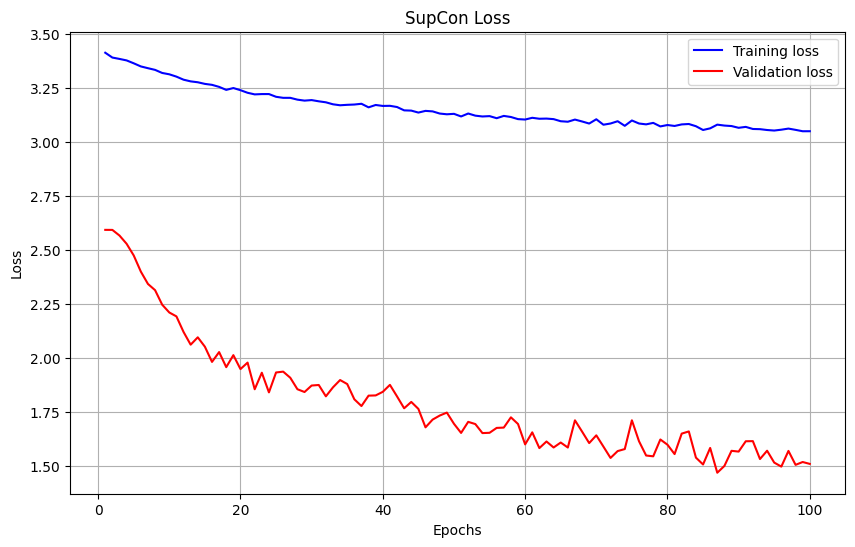

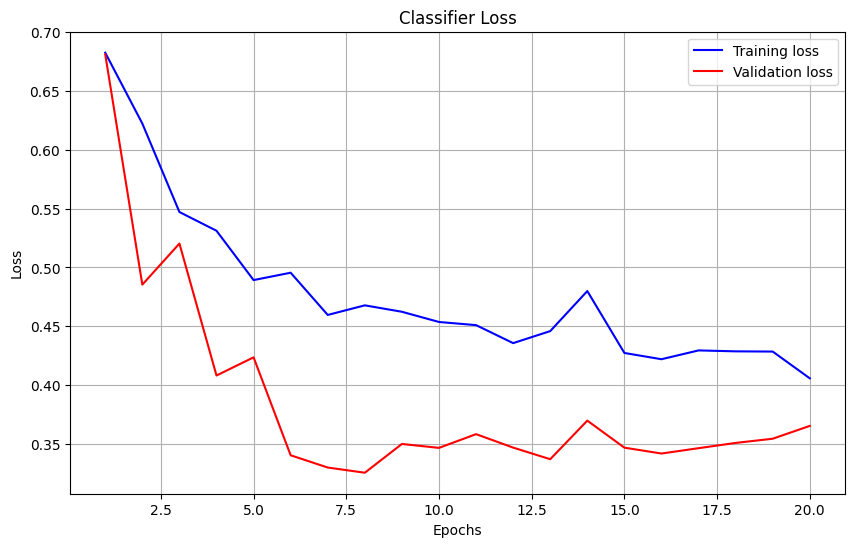


=== Evaluation Result ===
Accuracy:      0.710
Precision(M):  0.711
Recall(M):     0.710
F1 Macro:      0.709
F1 Weighted:   0.709
MCC:           0.420
Specificity:   0.742
ROC-AUC:       0.778

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.697     0.742     0.719        93
    Binding (1)      0.724     0.677     0.700        93

       accuracy                          0.710       186
      macro avg      0.711     0.710     0.709       186
   weighted avg      0.711     0.710     0.709       186



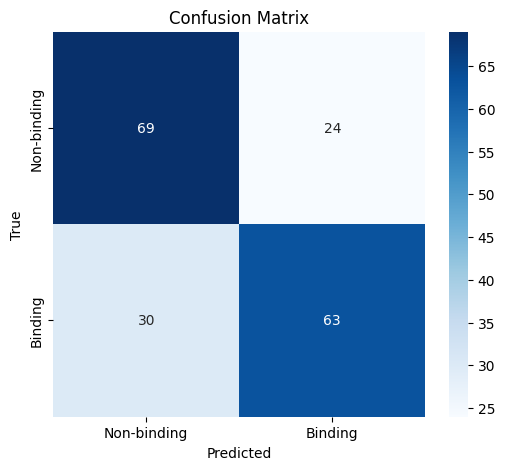

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_pdb_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_pdb_supcon, "trained_pdb_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_pdb_supcon, test_loader_pdb, device=device)




Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mulai train supcon...

🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.3544 | Val: 2.5834
Epoch 2/100 | Train: 3.2877 | Val: 2.5443
Epoch 3/100 | Train: 3.2523 | Val: 2.5315
Epoch 4/100 | Train: 3.2296 | Val: 2.5288
Epoch 5/100 | Train: 3.2185 | Val: 2.5018
Epoch 6/100 | Train: 3.2032 | Val: 2.5002
Epoch 7/100 | Train: 3.1985 | Val: 2.4835
Epoch 8/100 | Train: 3.1858 | Val: 2.4851
Epoch 9/100 | Train: 3.1780 | Val: 2.4812
Epoch 10/100 | Train: 3.1757 | Val: 2.4896
Epoch 11/100 | Train: 3.1708 | Val: 2.4806
Epoch 12/100 | Train: 3.1639 | Val: 2.4708
Epoch 13/100 | Train: 3.1606 | Val: 2.4707
Epoch 14/100 | Train: 3.1601 | Val: 2.4625
Epoch 15/100 | Train: 3.1608 | Val: 2.4588
Epoch 16/100 | Train: 3.1513 | Val: 2.4505
Epoch 17/100 | Train: 3.1487 | Val: 2.4595
Epoch 18/100 | Train: 3.1453 | Val: 2.4602
Epoch 19/100 | Train: 3.1461 | Val: 2.4549
Epoch 20/100 | Train: 3.1364 | Val: 2.4504
Epoch 21/100 | Train: 3.1363 | Val: 2.4689
Epoch 22/100 | Train: 3.1355 | Val: 2.4715

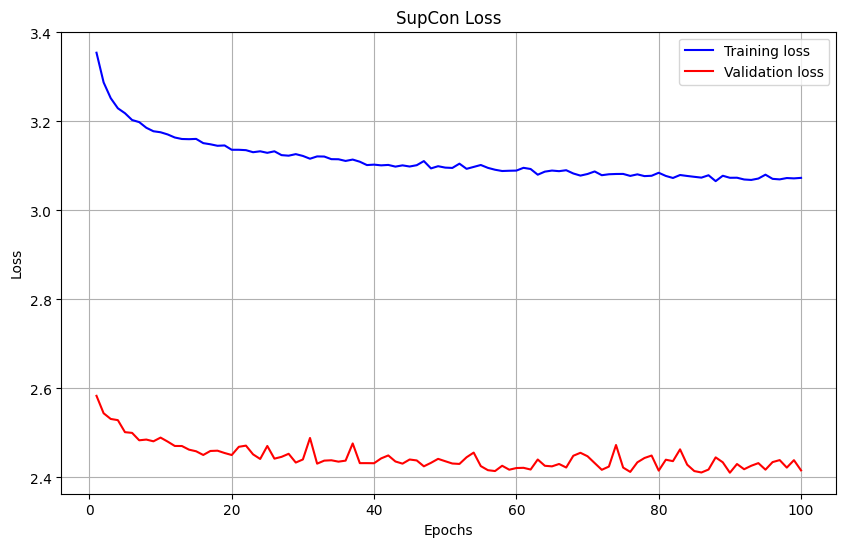

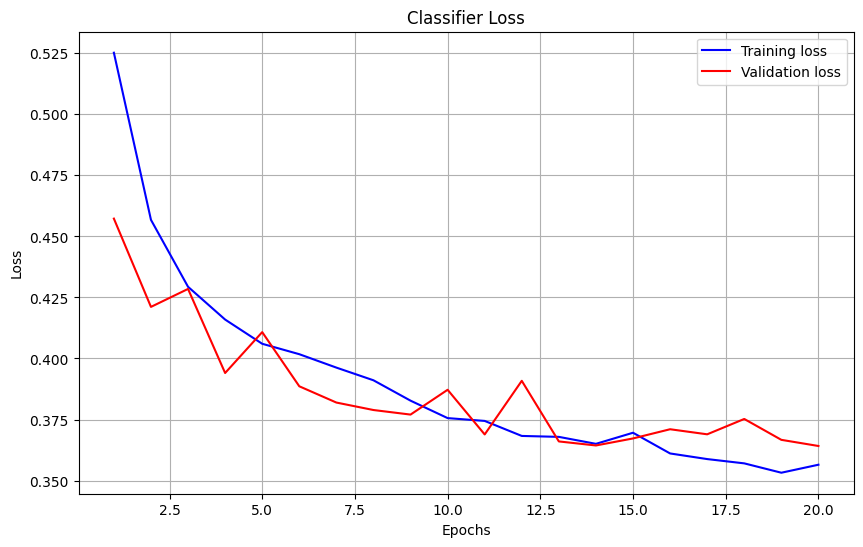


=== Evaluation Result ===
Accuracy:      0.825
Precision(M):  0.827
Recall(M):     0.825
F1 Macro:      0.825
F1 Weighted:   0.825
MCC:           0.652
Specificity:   0.795
ROC-AUC:       0.899

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.846     0.795     0.820       381
    Binding (1)      0.807     0.856     0.831       381

       accuracy                          0.825       762
      macro avg      0.827     0.825     0.825       762
   weighted avg      0.827     0.825     0.825       762



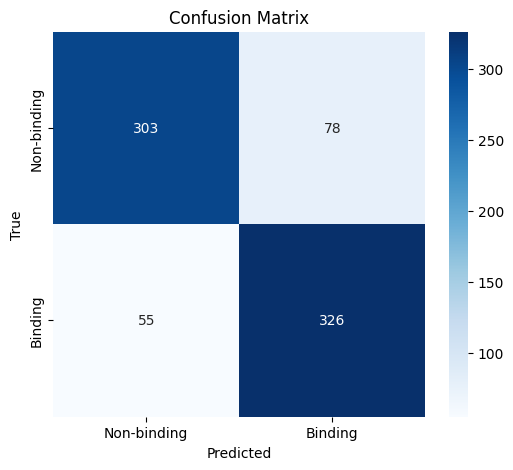

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_uni, val_loader_uni, epochs=100, lr=1e-4
)

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_uni, val_loader_uni
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_uni_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_uni_supcon, "trained_uni_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_uni_supcon, test_loader_uni, device=device)




In [ ]:
@torch.no_grad()
def evaluate_ensemble_multi_input(models, weights, dataloaders, device='cpu'):
    """
    Melakukan evaluasi ensemble dengan merata-ratakan LOGITS (sebelum Softmax) dari setiap model
    sesuai dengan bobot yang diberikan. Setiap model menerima Dataloader yang berbeda (Multi-Input).

    Parameters:
    models (list): List model PyTorch yang sudah dimuat (dalam mode .eval()).
    weights (list): List bobot (float) untuk setiap model, misal [0.7, 0.3].
    dataloaders (list): List Dataloader dari data test/validation, harus sama panjang dan berurutan dengan models.
    device (str): Perangkat ('cuda' atau 'cpu').

    Returns:
    tuple: (metrics_dict, y_pred, y_prob)
    """

    # 1. Inisialisasi
    if len(models) != len(dataloaders) or len(models) != len(weights):
        raise ValueError("Jumlah models, weights, dan dataloaders harus sama.")

    for model in models:
        model.eval()

    all_preds = []
    all_labels = []
    all_prob = []
    total_weight = sum(weights)

    print(f"\n--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: {[f'{w/total_weight:.2f}' for w in weights]} ---")

    # 2. Iterator Gabungan
    # Zip dataloaders: Mengambil batch secara paralel (harus sama panjang)
    combined_iterator = zip(*dataloaders)

    for batch_inputs in combined_iterator:

        logits_list = []

        # Ambil label dari Dataloader pertama (asumsi semua dataloader memiliki label yang sama)
        labels = batch_inputs[0][1].to(device)

        # 3. Loop Model dan Data Batch
        for i, (model, w) in enumerate(zip(models, weights)):
            # batch_inputs[i] adalah tuple (X_i, y_i) dari loader ke-i
            X_i = batch_inputs[i][0].to(device)

            # --- Forward Pass dengan Input Khusus ---
            # Jika model Anda membutuhkan unsqueeze (misal untuk CNN/BiLSTM pada sequence),
            # Anda perlu menambahkannya di sini, misalnya:
            # if model_type == 'BiLSTM': X_i = X_i.unsqueeze(1)

            # Logits dari Model Individual
            logits = model(X_i)

            # Bobot diterapkan pada Logits
            logits_list.append(w * logits)

        # 4. Logits Averaging dan Softmax
        combined_logits = torch.stack(logits_list).sum(0) / total_weight
        combined_prob = F.softmax(combined_logits, dim=1)
        preds = torch.argmax(combined_prob, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_prob.extend(combined_prob.cpu().numpy())

    # 5. Perhitungan Metrik
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_prob)

    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob[:, 1])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    class_report = classification_report(
        y_true, y_pred,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3,
        zero_division=0
    )

    # 6. Output & Visualisasi
    print("\n=== Evaluation Result ===")
    print(f"Accuracy:        {acc:.3f}")
    print(f"Precision(M):    {precision_macro:.3f}")
    print(f"Recall(M):       {recall_macro:.3f}")
    print(f"F1 Macro:        {f1_macro:.3f}")
    print(f"F1 Weighted:     {f1_weighted:.3f}")
    print(f"MCC:             {mcc:.3f}")
    print(f"Specificity:     {specificity:.3f}")
    print(f"ROC-AUC:         {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # Visualisasi Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-binding", "Binding"],
                yticklabels=["Non-binding", "Binding"])
    plt.title("Confusion Matrix Ensemble Logits Averaging (Multi-Input)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 7. Return
    metrics_dict = {
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "MCC": mcc,
        "Specificity": specificity,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }

    return metrics_dict, y_pred, y_prob

@torch.no_grad()
def esm_embed_sequences(seqs, esm_model, tokenizer):
    """
    Menghasilkan embedding CLS dari sekuens protein menggunakan model ESM.
    Fungsi ini dipanggil di lingkungan CPU.
    """
    device = esm_model.device
    embeddings = []

    # Set model ke eval (jika belum)
    esm_model.eval()

    # Perlu memproses setiap sekuens jika data input adalah list of strings
    for seq in seqs:
        tokens = tokenizer(
            seq,
            return_tensors="pt",
            truncation=True,
            max_length=1024,
            padding='max_length' # Asumsi: jika memproses satu per satu
        )

        # Pindahkan token ke perangkat target (CPU, karena DEVICE='cpu')
        tokens = {k: v.to(device) for k, v in tokens.items()}

        out = esm_model(**tokens)

        # Ambil CLS embedding, pindahkan hasilnya ke CPU, dan hapus dimensi 1
        cls = out.last_hidden_state[:, 0].squeeze().cpu()
        embeddings.append(cls)

    return torch.stack(embeddings) # tensor (N, D) di CPU

In [ ]:
class ComplexMLP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3, n_classes=2):
        super(ComplexMLP_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.BatchNorm1d(hidden_dim // 8),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 8, n_classes)
        )

    def forward(self, x):
        return self.model(x)


# Define the models
def define_model(model_type=None, input_dim=1280, hidden_dim=64, dropout=0.5, n_classes=2, embedding_dim=128, kernel_size=3, n_filters=64, nhead=4):
    if model_type == 'BiLSTM':
        pass # Added pass statement to fix IndentationError
    elif model_type == 'MLP':
        # ARCHITECTURAL CHANGE POINT: Modify number of hidden layers, activation functions, dropout positions
        model = ComplexMLP_v2(input_dim, hidden_dim, dropout, n_classes)

    else:
        raise ValueError("Model type not recognized. Choose from ['BiLSTM', 'CNN', 'Transformer', 'MLP']")

    return model

## Execution

### 7:3 (0.838)

--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 2. Loading ESM Model for 320D Embeddings ---


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA_VISIBLE_DEVICES diatur ke kosong.
Pengaturan CUDA_VISIBLE_DEVICES dihapus.

--- 3. Loading Trained Models to CPU ---

--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.70', '0.30'] ---

=== Evaluation Result ===
Accuracy:        0.887
Precision(M):    0.887
Recall(M):       0.887
F1 Macro:        0.887
F1 Weighted:     0.887
MCC:             0.775
Specificity:     0.871
ROC-AUC:         0.948

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.900     0.871     0.885        93
    Binding (1)      0.875     0.903     0.889        93

       accuracy                          0.887       186
      macro avg      0.887     0.887     0.887       186
   weighted avg      0.887     0.887     0.887       186



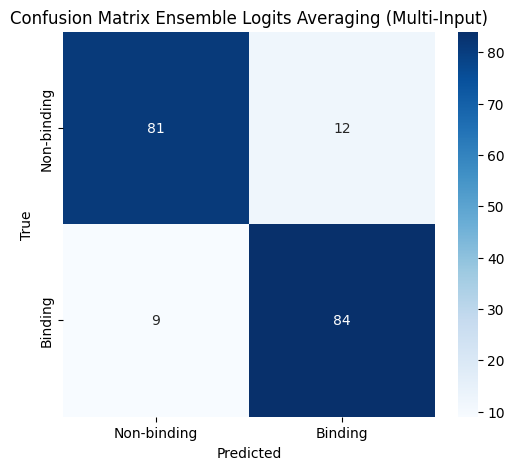

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.7, 0.3] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_pdb_test_emb_1280 = torch.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_test.pt", map_location='cpu').numpy()
y_pdb_test_1280 = np.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_test.npy")

test_ds_pdb_1280 = TensorDataset(
    torch.tensor(x_pdb_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_pdb_test_1280, dtype=torch.long)
)
test_loader_pdb_1280 = DataLoader(test_ds_pdb_1280, batch_size=32)


# --- 2.2 Persiapan Data Loader 320 (Dengan SupCon) ---
# Tambahkan pemuatan ESM model/tokenizer yang diperlukan oleh fungsi esm_embed_sequences
MODEL_NAME = "facebook/esm2_t6_8M_UR50D" # Asumsi model yang menghasilkan dimensi 320
print("\n--- 2. Loading ESM Model for 320D Embeddings ---")

# Muat model dan tokenizer ke CPU
tokenizer_global = AutoTokenizer.from_pretrained(MODEL_NAME)
esm_model_global = EsmModel.from_pretrained(MODEL_NAME).to(DEVICE)

# Sembunyikan semua GPU secara eksplisit saat membuat embedding (Walaupun sudah CPU, ini menjamin)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
print("CUDA_VISIBLE_DEVICES diatur ke kosong.")

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_pdb_test terdefinisi
x_pdb_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_pdb_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

# Hapus variabel lingkungan
del os.environ["CUDA_VISIBLE_DEVICES"]
print("Pengaturan CUDA_VISIBLE_DEVICES dihapus.")

y_pdb_test_320 = df_pdb_test['label'].values

test_ds_pdb_320 = TensorDataset(
    x_pdb_test_emb_320_tensor,
    torch.tensor(y_pdb_test_320, dtype=torch.long)
)
test_loader_pdb_320 = DataLoader(test_ds_pdb_320, batch_size=32)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_pdb = torch.load("/content/trained_pdb_model_full.pth", map_location=DEVICE, weights_only=False)
model_pdb_supcon = torch.load("/content/trained_pdb_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_pdb.eval()
model_pdb_supcon.eval()

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.7, 0.3] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_uni_test_emb_1280 = torch.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/x_uni_test.pt", map_location='cpu').numpy()
y_uni_test_1280 = np.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/y_uni_test.npy")

test_ds_uni_1280 = TensorDataset(
    torch.tensor(x_uni_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_uni_test_1280, dtype=torch.long)
)
test_loader_uni_1280 = DataLoader(test_ds_uni_1280, batch_size=32, drop_last=True)

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_uni_test terdefinisi
x_uni_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_uni_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

y_uni_test_320 = df_uni_test['label'].values

test_ds_uni_320 = TensorDataset(
    x_uni_test_emb_320_tensor,
    torch.tensor(y_uni_test_320, dtype=torch.long)
)
test_loader_uni_320 = DataLoader(test_ds_uni_320, batch_size=32, drop_last=True)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_uni = torch.load("/content/trained_uni_model_full.pth", map_location=DEVICE, weights_only=False)
model_uni_supcon = torch.load("/content/trained_uni_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_uni.eval()
model_uni_supcon.eval()



--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 3. Loading Trained Models to CPU ---


FullModel(
  (backbone): ESMBackbone(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 320, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-5): 6 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=320, out_features=320, bias=True)
                (key): Linear(in_features=320, out_features=320, bias=True)
                (value): Linear(in_features=320, out_features=320, bias=True)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
            )
            (intermediate): EsmI

In [ ]:
# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 5:5

In [ ]:
weights = [0.5, 0.5] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.5, 0.5] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 6:4


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.882
Precision(M):    0.882
Recall(M):       0.882
F1 Macro:        0.882
F1 Weighted:     0.882
MCC:             0.763
Specificity:     0.882
ROC-AUC:         0.949

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.882     0.882     0.882        93
    Binding (1)      0.882     0.882     0.882        93

       accuracy                          0.882       186
      macro avg      0.882     0.882     0.882       186
   weighted avg      0.882     0.882     0.882       186



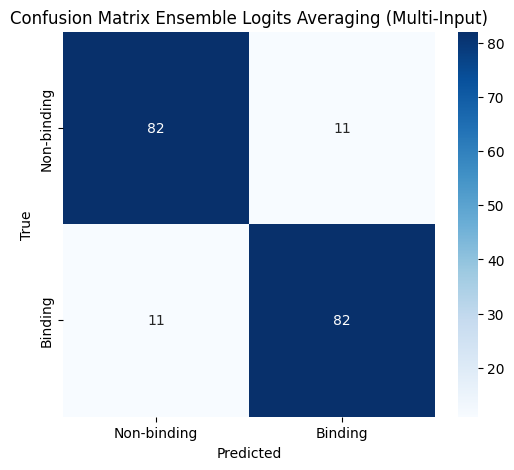

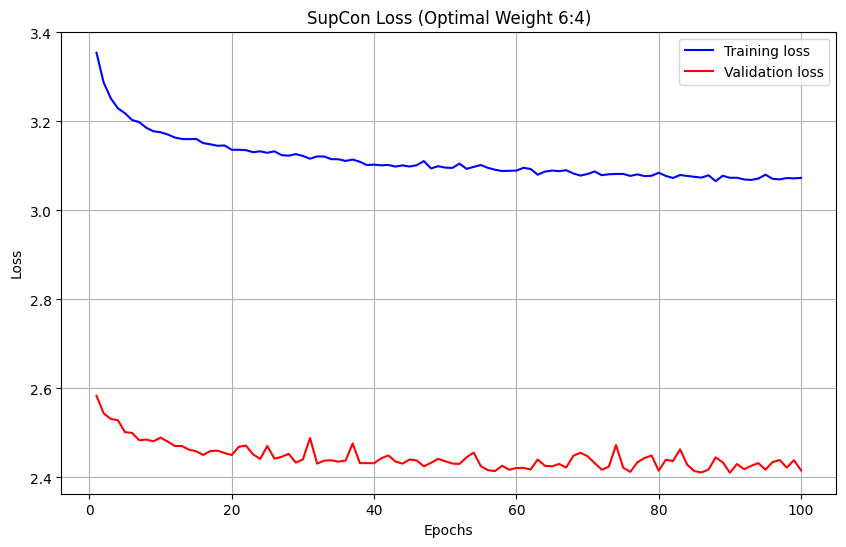

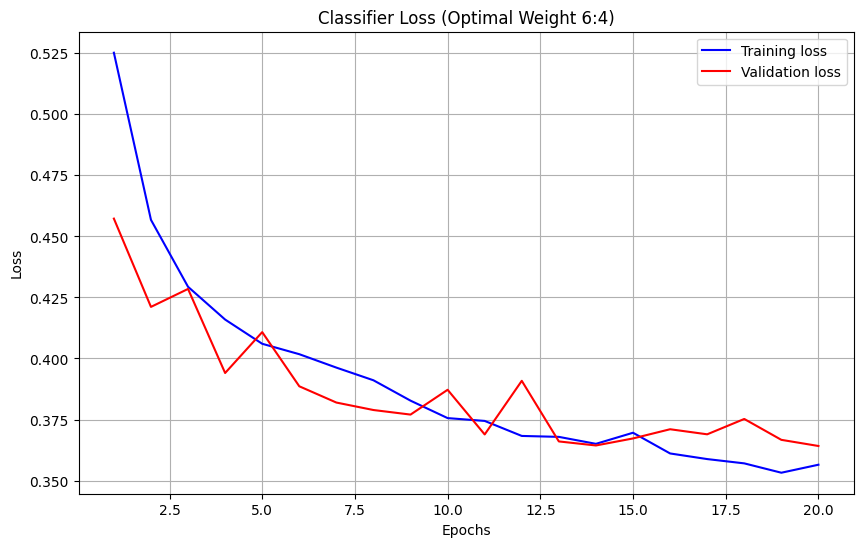

In [ ]:
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

plot_losses(supcon_train, supcon_val, "SupCon Loss (Optimal Weight 6:4)")
plot_losses(clf_train, clf_val, "Classifier Loss (Optimal Weight 6:4)")


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.917
Precision(M):    0.917
Recall(M):       0.918
F1 Macro:        0.917
F1 Weighted:     0.917
MCC:             0.835
Specificity:     0.933
ROC-AUC:         0.976

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.900     0.933     0.916       358
    Binding (1)      0.934     0.902     0.918       378

       accuracy                          0.917       736
      macro avg      0.917     0.918     0.917       736
   weighted avg      0.918     0.917     0.917       736



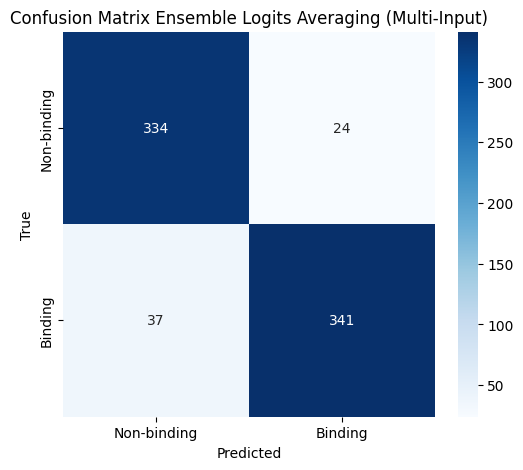

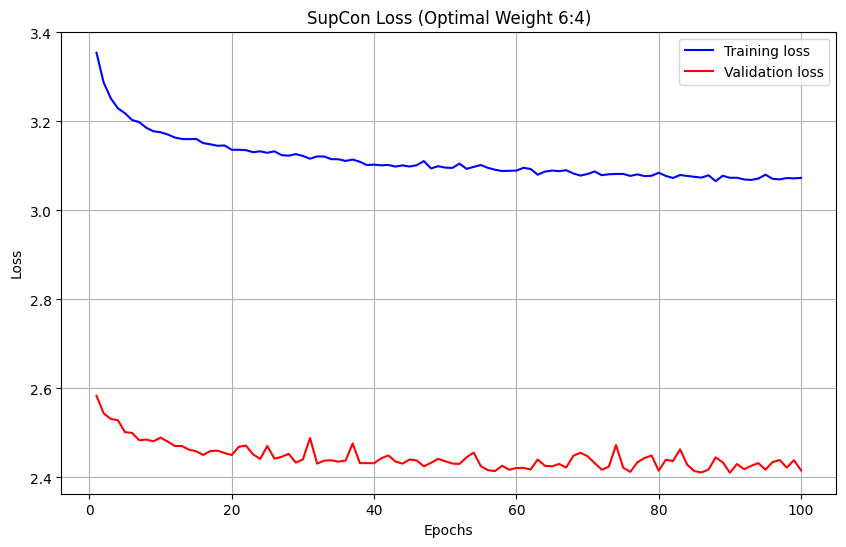

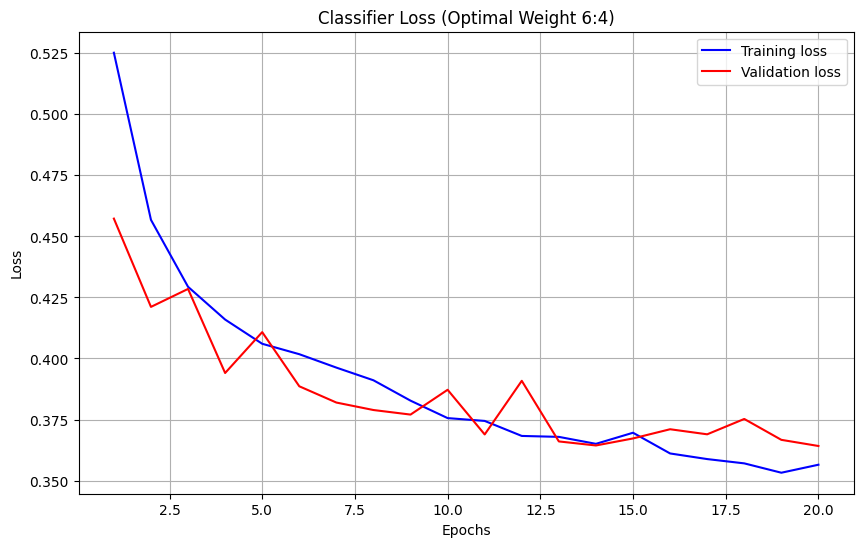

In [ ]:
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

plot_losses(supcon_train, supcon_val, "SupCon Loss (Optimal Weight 6:4)")
plot_losses(clf_train, clf_val, "Classifier Loss (Optimal Weight 6:4)")

### 8:2

In [ ]:
weights = [0.8, 0.2] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.8, 0.2] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 9:1

In [ ]:
weights = [0.9, 0.1] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.9, 0.1] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 4:6

In [ ]:
weights = [0.4, 0.6] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.4, 0.6] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 3:7

In [ ]:
weights = [0.3, 0.7] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.3, 0.7] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 2:8

In [ ]:
weights = [0.2, 0.8] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---


NameError: name 'model_pdb' is not defined

In [ ]:
weights = [0.2, 0.8] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---


NameError: name 'model_uni' is not defined

### 1:9

In [ ]:
weights = [0.1, 0.9] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
weights = [0.1, 0.9] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

## Execution 2


### 7:3

--- 1. Loading 1280D Embeddings for Validation ---
✓ Val loader 1280D: 99 samples
✓ Val loader 320D: 99 samples

--- 2. Loading Trained Models ---
✓ Models loaded: ComplexMLP_v2, FullModel

--- 3. Starting Ensemble Evaluation with evaluate_ensemble_multi_input ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.70', '0.30'] ---

=== Evaluation Result ===
Accuracy:        0.889
Precision(M):    0.887
Recall(M):       0.889
F1 Macro:        0.888
F1 Weighted:     0.889
MCC:             0.776
Specificity:     0.891
ROC-AUC:         0.952

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.907     0.891     0.899        55
    Binding (1)      0.867     0.886     0.876        44

       accuracy                          0.889        99
      macro avg      0.887     0.889     0.888        99
   weighted avg      0.889     0.889     0.889        99



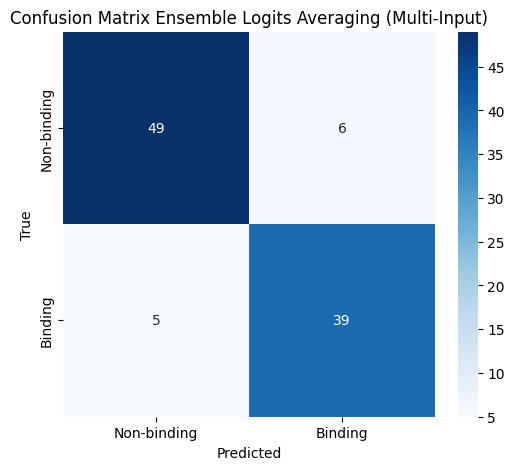


✅ ENSEMBLE EVALUATION COMPLETED!

Metrics: {'Accuracy': 0.8888888888888888, 'Precision_macro': 0.8870370370370371, 'Recall_macro': 0.8886363636363637, 'F1_macro': 0.887743531594681, 'F1_weighted': 0.8890034246183097, 'MCC': np.float64(0.7756717518813397), 'Specificity': np.float64(0.8909090909090909), 'ROC_AUC': np.float64(0.9520661157024795), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.907     0.891     0.899        55\n    Binding (1)      0.867     0.886     0.876        44\n\n       accuracy                          0.889        99\n      macro avg      0.887     0.889     0.888        99\n   weighted avg      0.889     0.889     0.889        99\n'}


In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.7, 0.3]

# ============================================================================
# PERSIAPAN DATA (seperti solusi sebelumnya)
# ============================================================================

print("--- 1. Loading 1280D Embeddings for Validation ---")
x_pdb_train_1280_full = torch.load(
    "/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_train.pt",
    map_location='cpu'
)
y_pdb_train_1280_full = np.load(
    "/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_train.npy"
)

# Split untuk validation
X_pdb_train_1280, X_pdb_val_1280, y_pdb_train_1280, y_pdb_val_1280 = train_test_split(
    x_pdb_train_1280_full,
    y_pdb_train_1280_full,
    test_size=0.1,
    random_state=42,
    stratify=y_pdb_train_1280_full
)

# DataLoader 1280D
val_ds_pdb_1280 = TensorDataset(
    X_pdb_val_1280 if torch.is_tensor(X_pdb_val_1280) else torch.tensor(X_pdb_val_1280, dtype=torch.float32),
    torch.tensor(y_pdb_val_1280, dtype=torch.long)
)
val_loader_pdb_1280 = DataLoader(val_ds_pdb_1280, batch_size=32, shuffle=False)

# DataLoader 320D (gunakan X_pdb_val yang sudah ada)
val_ds_pdb_320 = TensorDataset(
    X_pdb_val.clone().detach() if torch.is_tensor(X_pdb_val) else torch.tensor(X_pdb_val, dtype=torch.float32),
    torch.tensor(y_pdb_val, dtype=torch.long)
)
val_loader_pdb_320 = DataLoader(val_ds_pdb_320, batch_size=32, shuffle=False)

print(f"✓ Val loader 1280D: {len(val_ds_pdb_1280)} samples")
print(f"✓ Val loader 320D: {len(val_ds_pdb_320)} samples")

# ============================================================================
# MUAT MODEL
# ============================================================================

print("\n--- 2. Loading Trained Models ---")
model_pdb = torch.load("/content/trained_pdb_model_full.pth", map_location=DEVICE, weights_only=False)
model_pdb_supcon = torch.load("/content/trained_pdb_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_pdb.eval()
model_pdb_supcon.eval()

print(f"✓ Models loaded: {type(model_pdb).__name__}, {type(model_pdb_supcon).__name__}")

# ============================================================================
# ✅ PANGGIL FUNGSI EVALUATE_ENSEMBLE_MULTI_INPUT
# ============================================================================

print("\n--- 3. Starting Ensemble Evaluation with evaluate_ensemble_multi_input ---")

metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],           # [Model 1280D, Model 320D]
    weights=weights,                                 # [0.7, 0.3]
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],  # [Loader 1280D, Loader 320D]
    device=DEVICE
)

print("\n" + "="*80)
print("✅ ENSEMBLE EVALUATION COMPLETED!")
print("="*80)
print(f"\nMetrics: {metrics}")


### 5:5


🔄 Testing new weights: [0.5, 0.5]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.50', '0.50'] ---

=== Evaluation Result ===
Accuracy:        0.889
Precision(M):    0.887
Recall(M):       0.889
F1 Macro:        0.888
F1 Weighted:     0.889
MCC:             0.776
Specificity:     0.891
ROC-AUC:         0.957

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.907     0.891     0.899        55
    Binding (1)      0.867     0.886     0.876        44

       accuracy                          0.889        99
      macro avg      0.887     0.889     0.888        99
   weighted avg      0.889     0.889     0.889        99



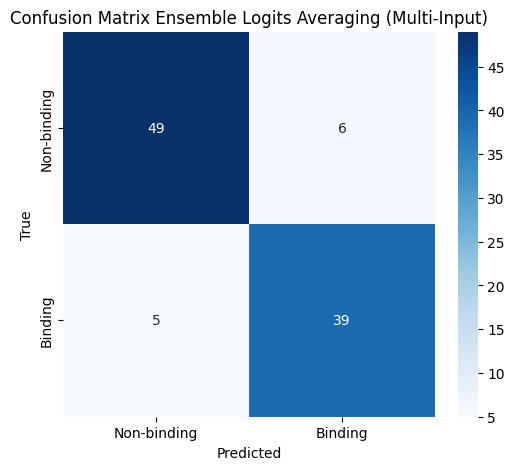


Metrics: {'Accuracy': 0.8888888888888888, 'Precision_macro': 0.8870370370370371, 'Recall_macro': 0.8886363636363637, 'F1_macro': 0.887743531594681, 'F1_weighted': 0.8890034246183097, 'MCC': np.float64(0.7756717518813397), 'Specificity': np.float64(0.8909090909090909), 'ROC_AUC': np.float64(0.9570247933884297), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.907     0.891     0.899        55\n    Binding (1)      0.867     0.886     0.876        44\n\n       accuracy                          0.889        99\n      macro avg      0.887     0.889     0.888        99\n   weighted avg      0.889     0.889     0.889        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.5, 0.5]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 6:4 (Best)


🔄 Testing new weights: [0.6, 0.4]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.909
Precision(M):    0.907
Recall(M):       0.909
F1 Macro:        0.908
F1 Weighted:     0.909
MCC:             0.816
Specificity:     0.909
ROC-AUC:         0.958

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.926     0.909     0.917        55
    Binding (1)      0.889     0.909     0.899        44

       accuracy                          0.909        99
      macro avg      0.907     0.909     0.908        99
   weighted avg      0.909     0.909     0.909        99



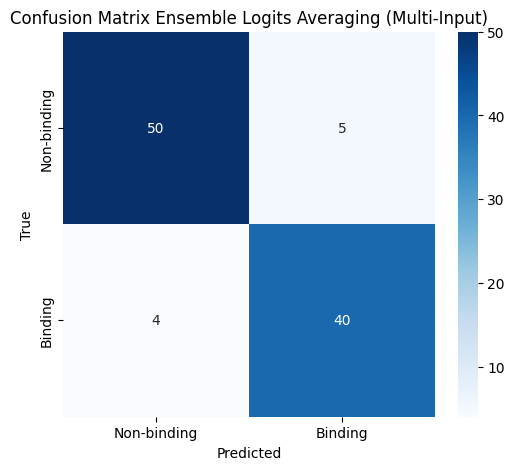


Metrics: {'Accuracy': 0.9090909090909091, 'Precision_macro': 0.9074074074074074, 'Recall_macro': 0.9090909090909091, 'F1_macro': 0.9081537985774663, 'F1_weighted': 0.9091846201422534, 'MCC': np.float64(0.8164965809277261), 'Specificity': np.float64(0.9090909090909091), 'ROC_AUC': np.float64(0.9582644628099173), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.926     0.909     0.917        55\n    Binding (1)      0.889     0.909     0.899        44\n\n       accuracy                          0.909        99\n      macro avg      0.907     0.909     0.908        99\n   weighted avg      0.909     0.909     0.909        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.6, 0.4]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 8:2


🔄 Testing new weights: [0.8, 0.2]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.80', '0.20'] ---

=== Evaluation Result ===
Accuracy:        0.818
Precision(M):    0.816
Recall(M):       0.816
F1 Macro:        0.816
F1 Weighted:     0.818
MCC:             0.632
Specificity:     0.836
ROC-AUC:         0.934

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.836     0.836     0.836        55
    Binding (1)      0.795     0.795     0.795        44

       accuracy                          0.818        99
      macro avg      0.816     0.816     0.816        99
   weighted avg      0.818     0.818     0.818        99



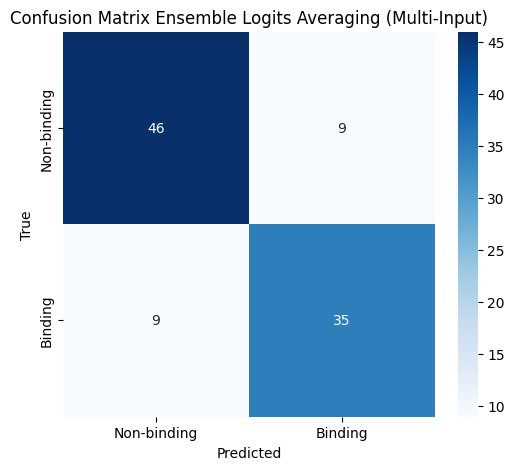


Metrics: {'Accuracy': 0.8181818181818182, 'Precision_macro': 0.8159090909090909, 'Recall_macro': 0.8159090909090909, 'F1_macro': 0.8159090909090909, 'F1_weighted': 0.8181818181818182, 'MCC': np.float64(0.6318181818181818), 'Specificity': np.float64(0.8363636363636363), 'ROC_AUC': np.float64(0.934297520661157), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.836     0.836     0.836        55\n    Binding (1)      0.795     0.795     0.795        44\n\n       accuracy                          0.818        99\n      macro avg      0.816     0.816     0.816        99\n   weighted avg      0.818     0.818     0.818        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.8, 0.2]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 9:1


🔄 Testing new weights: [0.9, 0.1]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.90', '0.10'] ---

=== Evaluation Result ===
Accuracy:        0.798
Precision(M):    0.796
Recall(M):       0.798
F1 Macro:        0.796
F1 Weighted:     0.798
MCC:             0.593
Specificity:     0.800
ROC-AUC:         0.906

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.830     0.800     0.815        55
    Binding (1)      0.761     0.795     0.778        44

       accuracy                          0.798        99
      macro avg      0.796     0.798     0.796        99
   weighted avg      0.799     0.798     0.798        99



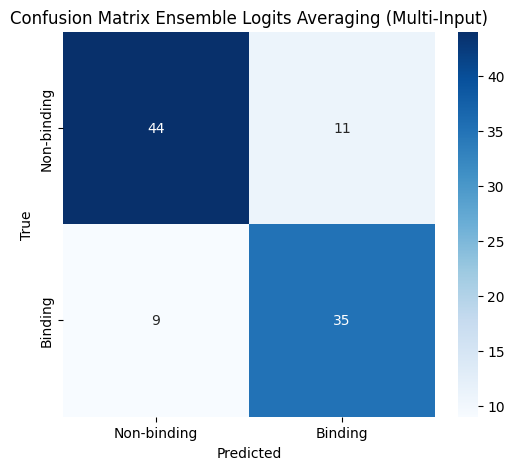


Metrics: {'Accuracy': 0.797979797979798, 'Precision_macro': 0.7955291222313372, 'Recall_macro': 0.7977272727272727, 'F1_macro': 0.7962962962962963, 'F1_weighted': 0.7983539094650206, 'MCC': np.float64(0.5932523226197124), 'Specificity': np.float64(0.8), 'ROC_AUC': np.float64(0.906198347107438), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.830     0.800     0.815        55\n    Binding (1)      0.761     0.795     0.778        44\n\n       accuracy                          0.798        99\n      macro avg      0.796     0.798     0.796        99\n   weighted avg      0.799     0.798     0.798        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.9, 0.1]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 4:6


🔄 Testing new weights: [0.4, 0.6]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.40', '0.60'] ---

=== Evaluation Result ===
Accuracy:        0.889
Precision(M):    0.888
Recall(M):       0.886
F1 Macro:        0.887
F1 Weighted:     0.889
MCC:             0.775
Specificity:     0.909
ROC-AUC:         0.956

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.893     0.909     0.901        55
    Binding (1)      0.884     0.864     0.874        44

       accuracy                          0.889        99
      macro avg      0.888     0.886     0.887        99
   weighted avg      0.889     0.889     0.889        99



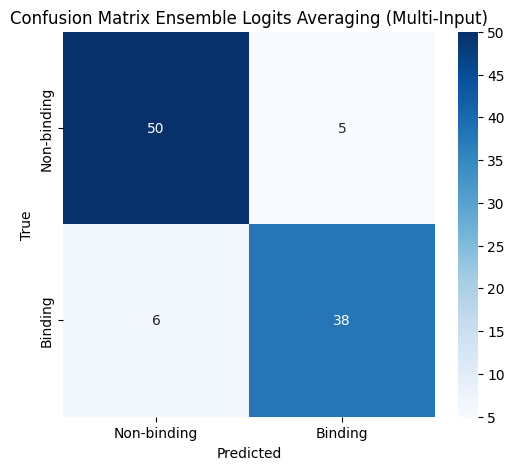


Metrics: {'Accuracy': 0.8888888888888888, 'Precision_macro': 0.8882890365448506, 'Recall_macro': 0.8863636363636364, 'F1_macro': 0.8872320596458527, 'F1_weighted': 0.8887508197853027, 'MCC': np.float64(0.7746502801125198), 'Specificity': np.float64(0.9090909090909091), 'ROC_AUC': np.float64(0.956198347107438), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.893     0.909     0.901        55\n    Binding (1)      0.884     0.864     0.874        44\n\n       accuracy                          0.889        99\n      macro avg      0.888     0.886     0.887        99\n   weighted avg      0.889     0.889     0.889        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.4, 0.6]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 3:7


🔄 Testing new weights: [0.3, 0.7]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.30', '0.70'] ---

=== Evaluation Result ===
Accuracy:        0.889
Precision(M):    0.888
Recall(M):       0.886
F1 Macro:        0.887
F1 Weighted:     0.889
MCC:             0.775
Specificity:     0.909
ROC-AUC:         0.944

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.893     0.909     0.901        55
    Binding (1)      0.884     0.864     0.874        44

       accuracy                          0.889        99
      macro avg      0.888     0.886     0.887        99
   weighted avg      0.889     0.889     0.889        99



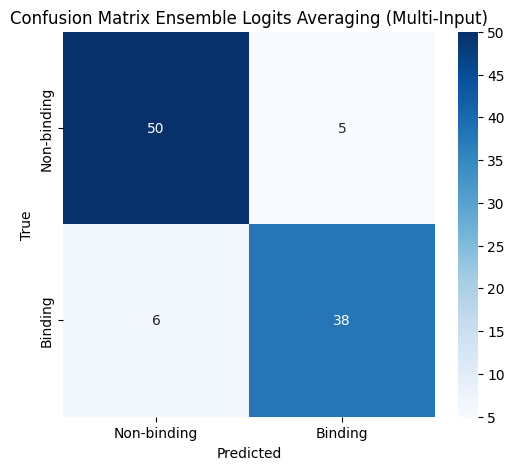


Metrics: {'Accuracy': 0.8888888888888888, 'Precision_macro': 0.8882890365448506, 'Recall_macro': 0.8863636363636364, 'F1_macro': 0.8872320596458527, 'F1_weighted': 0.8887508197853027, 'MCC': np.float64(0.7746502801125198), 'Specificity': np.float64(0.9090909090909091), 'ROC_AUC': np.float64(0.9438016528925619), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.893     0.909     0.901        55\n    Binding (1)      0.884     0.864     0.874        44\n\n       accuracy                          0.889        99\n      macro avg      0.888     0.886     0.887        99\n   weighted avg      0.889     0.889     0.889        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.3, 0.7]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 2:8


🔄 Testing new weights: [0.2, 0.8]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.20', '0.80'] ---

=== Evaluation Result ===
Accuracy:        0.879
Precision(M):    0.877
Recall(M):       0.877
F1 Macro:        0.877
F1 Weighted:     0.879
MCC:             0.755
Specificity:     0.891
ROC-AUC:         0.933

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.891     0.891     0.891        55
    Binding (1)      0.864     0.864     0.864        44

       accuracy                          0.879        99
      macro avg      0.877     0.877     0.877        99
   weighted avg      0.879     0.879     0.879        99



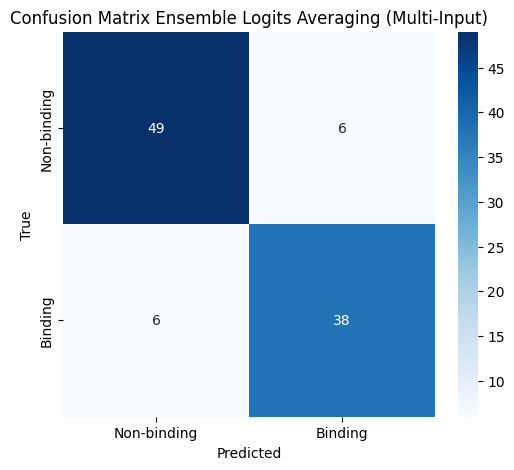


Metrics: {'Accuracy': 0.8787878787878788, 'Precision_macro': 0.8772727272727272, 'Recall_macro': 0.8772727272727272, 'F1_macro': 0.8772727272727272, 'F1_weighted': 0.8787878787878788, 'MCC': np.float64(0.7545454545454545), 'Specificity': np.float64(0.8909090909090909), 'ROC_AUC': np.float64(0.9326446280991736), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.891     0.891     0.891        55\n    Binding (1)      0.864     0.864     0.864        44\n\n       accuracy                          0.879        99\n      macro avg      0.877     0.877     0.877        99\n   weighted avg      0.879     0.879     0.879        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.2, 0.8]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")


### 1:9


🔄 Testing new weights: [0.1, 0.9]

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.10', '0.90'] ---

=== Evaluation Result ===
Accuracy:        0.859
Precision(M):    0.856
Recall(M):       0.859
F1 Macro:        0.857
F1 Weighted:     0.859
MCC:             0.716
Specificity:     0.855
ROC-AUC:         0.922

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.887     0.855     0.870        55
    Binding (1)      0.826     0.864     0.844        44

       accuracy                          0.859        99
      macro avg      0.856     0.859     0.857        99
   weighted avg      0.860     0.859     0.859        99



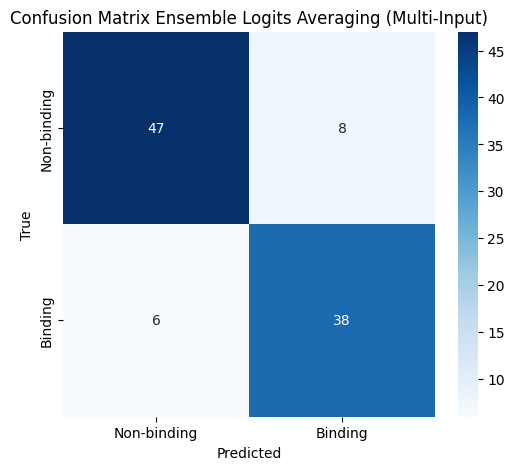


Metrics: {'Accuracy': 0.8585858585858586, 'Precision_macro': 0.856439704675964, 'Recall_macro': 0.8590909090909091, 'F1_macro': 0.8574074074074074, 'F1_weighted': 0.8588477366255143, 'MCC': np.float64(0.7155257020909508), 'Specificity': np.float64(0.8545454545454545), 'ROC_AUC': np.float64(0.9223140495867769), 'Classification_Report': '                 precision    recall  f1-score   support\n\nNon-binding (0)      0.887     0.855     0.870        55\n    Binding (1)      0.826     0.864     0.844        44\n\n       accuracy                          0.859        99\n      macro avg      0.856     0.859     0.857        99\n   weighted avg      0.860     0.859     0.859        99\n'}


In [ ]:
# Cell baru - coba weight berbeda
weights_new = [0.1, 0.9]  # atau [0.8, 0.2], [0.6, 0.4], dll

print(f"\n🔄 Testing new weights: {weights_new}")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights_new,
    dataloaders=[val_loader_pdb_1280, val_loader_pdb_320],
    device=DEVICE
)

print(f"\nMetrics: {metrics}")
